In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings

## Load Data

### Migration influx

In [4]:
df_all = pd.read_csv(
    "../../data/processed/registrations/registrations_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")
df_all["value"].fillna(1.0, inplace=True) # at least 1 person per timeframe for multiplicative seasonal decomposition

with open("../../data/config/country_names_registrations.json") as buf:
    countries = list(json.load(buf).keys())

series = {c: df_all[df_all.country==c].value for c in countries}
series["NL"]

date
2008-01-01     964.0
2008-02-01     883.0
2008-03-01     829.0
2008-04-01     956.0
2008-05-01     713.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 144, dtype: float64

### Google trends

In [6]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../../data/config/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../../data/processed/trends/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]].columns.get_level_values(1)

dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1140: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


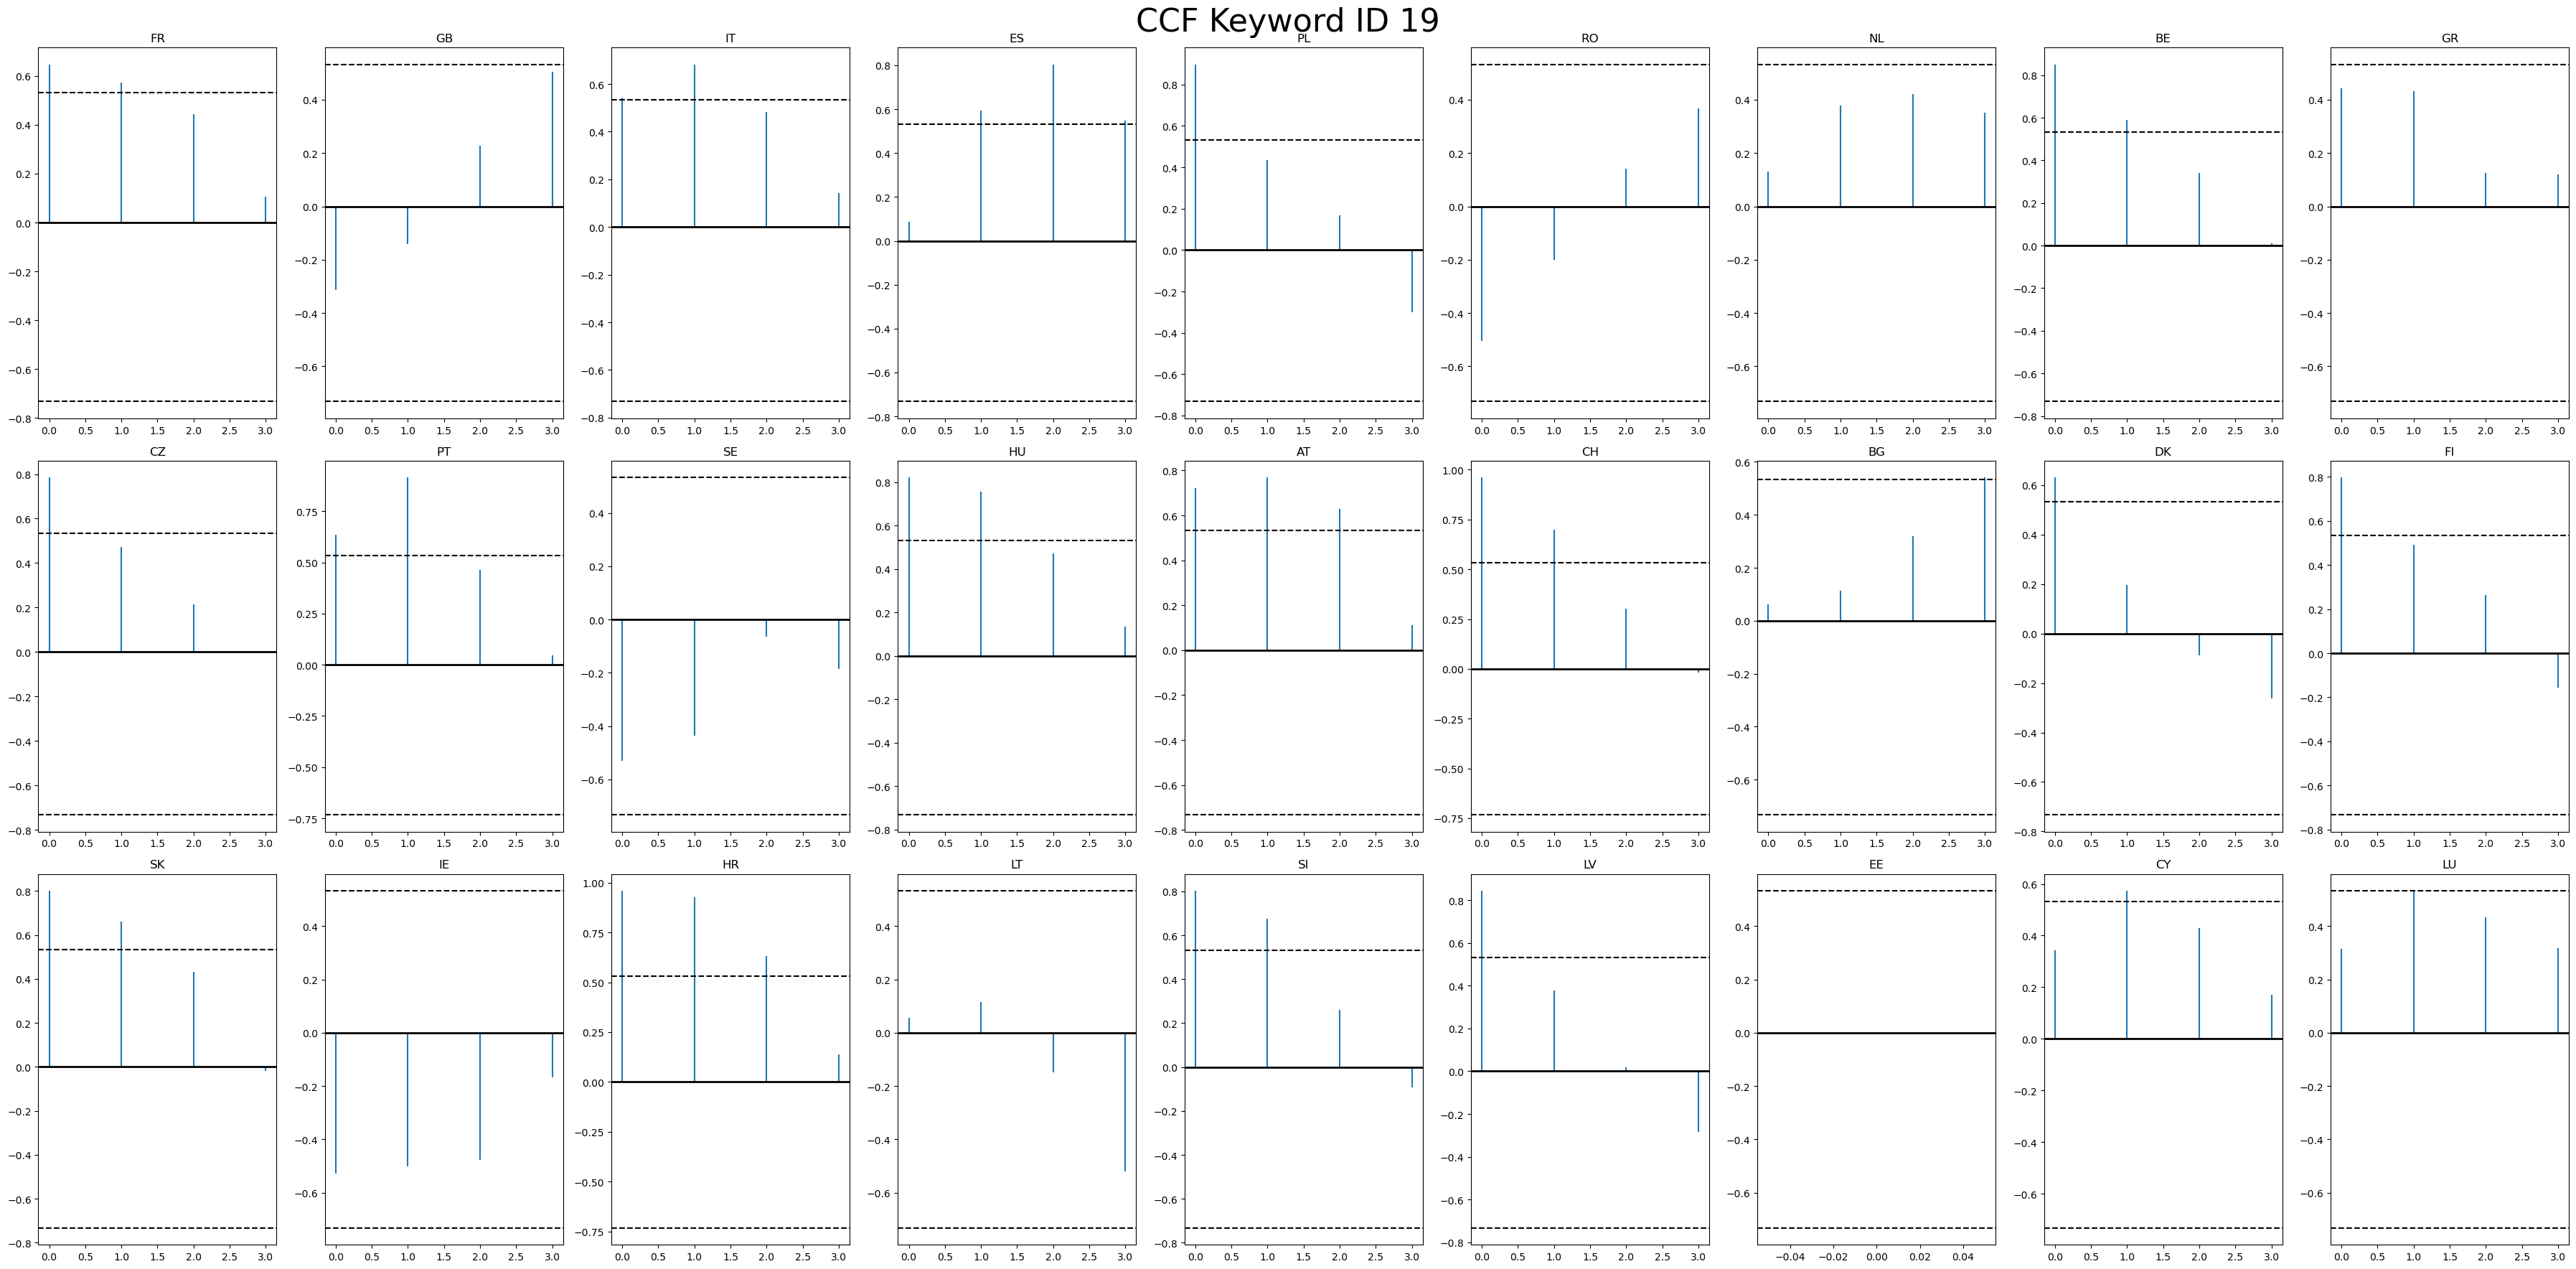

In [7]:
def plot_crosscorrelation(
    k_id,
    dfs_trends,
    ss_migration,
    countries,
    n_cols=9,
    n_lags=4,
    title=None,
    t_min="2010",
    t_max="2019",
):

    n_rows = math.ceil(len(countries) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):

            ax = axs[i, j]
            country = countries[i * n_cols + j]

            y = dfs_trends[country]["mean", k_id]
            x = ss_migration[country]

            cross_corr = sm.tsa.ccf(x[t_min:t_max], y[t_min:t_max])

            n = len(x[t_min:t_max])
            ci_u, ci_l = -1 / n + 2 / np.sqrt(n), -1 / n - 2 / np.sqrt(n)

            ax.vlines(range(n_lags), 0, cross_corr[:n_lags])
            ax.axhline(0, c="black", lw=2)
            ax.axhline(ci_u, ls="--", c="black")
            ax.axhline(ci_l, ls="--", c="black")

            ax.set_title(country)

    if title is not None:
        fig.suptitle(title + " Keyword ID " + k_id, fontsize=32)
    plt.tight_layout()
    return fig

dfs_1y = {k: df.resample("1Y").mean() for k, df in dataframes.items()}
sers_1y = {k: df.resample("1Y").mean() for k, df in series.items()}

plot_crosscorrelation(
    "19",
    dfs_1y,
    sers_1y,
    countries,
    title="CCF",
)
plt.show()

,2,10,11,12,14,15,16,17,18,19,...,114,115,117,118,119,121,122,123,124,125
FR,0.262238,0.604404,0.401994,0.922375,0.068792,0.550891,-0.039808,0.146652,NaN,0.800782,...,0.260327,0.463718,-0.551442,-0.281544,0.772553,0.379536,0.398855,-0.612137,0.504200,0.552714
GB,0.883814,0.358491,0.603583,0.903503,0.822028,0.533639,0.181392,-0.314858,NaN,0.041585,...,0.953878,-0.942180,0.522908,-0.970045,0.833818,0.963673,0.936956,-0.390262,0.981099,-0.785435
IT,0.219812,0.434774,0.788681,0.676350,0.790432,0.881417,0.837379,0.743006,NaN,0.810334,...,0.502918,0.524764,0.040276,-0.779991,-0.260543,0.450393,0.665675,-0.308606,0.612514,-0.870039
ES,0.037876,0.689059,0.006569,0.624502,0.785446,0.758183,0.690517,-0.170106,NaN,0.677655,...,-0.003465,0.628570,-0.673292,0.577048,0.239097,-0.239654,-0.302394,-0.089572,-0.294064,-0.079158
PL,-0.564955,-0.331401,-0.573587,-0.089889,-0.194183,0.310779,NaN,0.238790,0.005021,0.686212,...,-0.060141,0.229635,0.476247,0.704170,0.088766,-0.298184,0.476832,0.091904,-0.426785,-0.259767
RO,NaN,NaN,0.339529,0.934424,0.166854,NaN,NaN,NaN,NaN,0.152631,...,0.427978,-0.172816,-0.281916,0.916520,0.965718,0.621007,-0.118049,-0.932448,0.726558,0.806628
NL,0.547353,-0.038194,0.335855,0.774462,0.671851,0.209569,0.202082,-0.285441,-0.261142,0.504851,...,-0.082326,0.300225,-0.415167,0.560165,-0.234063,0.289433,-0.245593,-0.104258,0.429088,0.754769
BE,0.191020,NaN,0.737199,NaN,0.778679,NaN,NaN,NaN,NaN,0.806870,...,0.578143,0.661650,-0.329698,0.138675,0.812333,0.918715,0.602196,0.840699,0.621673,0.371420
GR,NaN,NaN,0.041823,NaN,0.585082,NaN,NaN,NaN,NaN,0.841819,...,0.284970,-0.089804,-0.659279,0.004432,0.651470,0.202973,-0.391962,0.359075,0.077490,0.163069
CZ,NaN,NaN,-0.343290,0.521177,NaN,NaN,NaN,NaN,NaN,0.726609,...,-0.876459,-0.679236,-0.587601,-0.252312,-0.485906,-0.447948,-0.670231,-0.470917,0.640051,0.120763


In [89]:
def get_corr_table(lag = 1, **kwargs):

    sers = {}
    for k in keyword_ids:
        corr = []
        for c in countries:
            x_ind = dataframes[c]["mean"][k].resample("1Y").mean()
            x_dep = series[c].resample("1Y").mean()

            corr.append(x_dep.corr(x_ind.shift(lag), **kwargs))
        corr = pd.Series(corr, index=countries)
        sers[k] = corr
    return pd.DataFrame(sers)



In [91]:
df_pearson_1y = get_corr_table()
#df_pearson_1y.to_excel("data/corr_pearson_1y.xlsx")

df_pearson_m1y = get_corr_table(lag=-1)
#df_pearson_m1y.to_excel("data/corr_pearson_-1y.xlsx")
